In [23]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
# import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import string
import gc, os, shutil

from modules import *

## Obtain Brill-Lindquist

In [ ]:
y_init = -1
y_final = 1
x_bounds = (-0.5, 0.5)
z_bounds = (-0.5, 0.5)


# black hole configuration
BH_res = 3
positions = []

masses = np.zeros((BH_res, BH_res, BH_res))

Layer1_center = (1, 1, 2)  # Layer1 center
Layer2_top_row_center = (1, 0, 1)  # Layer2 top row center
Layer2_center = (1, 1, 1)  # Layer2 center
Layer2_bottom_left = (0, 2, 1)  # Layer2 bottom-left
Layer2_bottom_right = (2, 2, 1)  # Layer2 bottom-right
Layer3_center = (1, 1, 0)  # Layer3 center

# masses[Layer1_center] = 0.01
# masses[Layer3_center] = 0.05
masses[Layer2_center] = 0.07
# masses[Layer2_top_row_center] = 0.04
masses[Layer2_bottom_left] = 0.2
masses[Layer2_bottom_right] = 0.1


masses = masses.flatten() + np.random.rand(27) * 0
# masses = masses_presoftplus + np.abs(np.random.normal(loc=0, scale=5, size=masses_presoftplus.shape))

x_coords = np.linspace(-0.5, 0.5, BH_res)
y_coords = np.linspace(-0.5, 0.5, BH_res)
z_coords = np.linspace(-0.5, 0.5, BH_res)   
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        for k, z in enumerate(z_coords):
            positions.append([x, y, z])
            
initial_xzs = [[1.4537, 1.4262], [0.6900, 0.3308], [1.1884, 0.3580], [0.1530, 1.9874]]
initial_xs = (torch.tensor([[xz[0], y_init, xz[1]] for xz in initial_xzs], device='cuda') - 1.0) / 2.0
initial_vs = torch.tensor([[0, 8.0, 0] for xz in initial_xzs], device='cuda')


final_xzs = [[1.0249249935150146, -0.7840133309364319], 
             [0.8142625093460083, -0.3116571903228760],
             [0.7874888181686401, -0.5534397959709167], 
             [-0.8091279864311218, 1.6983491182327271]]
final_xzs = torch.tensor(final_xzs, device='cuda')

In [26]:
BH_locs = positions
BH_masses = masses

ODEfunc = NeuralODEfunc(BH_masses_presoftplus=BH_masses, BH_positions=BH_locs, BH_masses=BH_masses,
                        max_x=2.0, device='cuda')
phi, chi, alpha = ODEfunc.BrillLindquist_init()
beta = torch.zeros((ODEfunc.res, ODEfunc.res, ODEfunc.res, 3), device='cuda')
B = torch.zeros((ODEfunc.res, ODEfunc.res, ODEfunc.res, 3), device='cuda')

gamma_bar_mat_lo, _, _, _, \
Gamma, _, _, _, Gamma_bar, \
K, A_bar_mat_lo, _, _, \
_, _, _ =  ODEfunc.init_non_evolve_vars(phi)

BH_masses stats: min, max, mean: 0.0 0.20000000298023224 0.013703703880310059
Preparing Variables


## Torchdiffeq

In [4]:
from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint_event

In [5]:
terminating_y = 1.0
# terminating_v = 0.5

def terminate_func(t, y_packed):
    y = y_packed[-2]
    flag = torch.ones(y.shape[0], device='cuda')
    for i in range(len(y)):
        if y[i][1] >= terminating_y:
            flag[i] = 0
    if torch.isnan(y_packed[-4]):
        flag[0] = 0
    if torch.isnan(y_packed[-3]):
        flag[0] = 0
    if y_packed[-4] > 5:
        flag[0] = 0
    if y_packed[-3] > 5:
        flag[0] = 0
    if t > 1.38:
        flag[0] = 0
#     for i in range(len(y[0])):
#         if torch.sum(torch.square(y[1][i][1:])) <= terminating_v:
#             flag[i] = 0
    return flag

In [129]:
hc = torch.tensor(0.0, device='cuda')
mc = torch.tensor(0.0, device='cuda')
x0 = initial_xs[1:2]
v0 = initial_vs[1:2]
y0 = (alpha, beta, chi, gamma_bar_mat_lo, Gamma_bar, A_bar_mat_lo, K, B, hc, mc, x0, v0)
t_final, sol = odeint_event(ODEfunc, y0, torch.tensor([0.0]), event_fn=terminate_func, 
                            reverse_time=False, odeint_interface=odeint, rtol=1e-4, atol=1e-4)

time:  0.0
Updating functions
Hamiltonian Constraint:  0.13827814161777496
Momentum Constraint:  0.0
time:  0.0009928849758580327
Updating functions
Hamiltonian Constraint:  0.13827814161777496
Momentum Constraint:  0.0013942192308604717
time:  0.006644663866609335
Updating functions
Hamiltonian Constraint:  0.13827815651893616
Momentum Constraint:  0.0093305055052042
time:  0.009966996498405933
Updating functions
Hamiltonian Constraint:  0.13827823102474213
Momentum Constraint:  0.013995754532516003
time:  0.02657865546643734
Updating functions
Hamiltonian Constraint:  0.13827797770500183
Momentum Constraint:  0.03731607273221016
time:  0.02953184023499489
Updating functions
Hamiltonian Constraint:  0.13827763497829437
Momentum Constraint:  0.04146064817905426
time:  0.033223316073417664
Updating functions
Hamiltonian Constraint:  0.13827751576900482
Momentum Constraint:  0.04664134606719017
time:  0.033223316073417664
Updating functions
Hamiltonian Constraint:  0.1382780820131302
Mom

In [117]:
hc = torch.tensor(0.0, device='cuda')
mc = torch.tensor(0.0, device='cuda')
x0 = initial_xs[0:4]
v0 = initial_vs[0:4]
y0 = (alpha, beta, chi, gamma_bar_mat_lo, Gamma_bar, A_bar_mat_lo, K, B, hc, mc, x0, v0)
# t_final, sol = odeint_event(ODEfunc, y0, torch.tensor([0.0]), event_fn=terminate_func, 
#                             reverse_time=False, odeint_interface=odeint, rtol=1e-4, atol=1e-4)
sol = odeint(ODEfunc, y0, torch.linspace(0, 1.40, 40), rtol=1e-4, atol=1e-4)

time:  0.0
Updating functions
Hamiltonian Constraint:  0.13827814161777496
Momentum Constraint:  0.0
time:  0.0009329742752015591
Updating functions
Hamiltonian Constraint:  0.13827814161777496
Momentum Constraint:  0.001310091931372881
time:  0.006258957087993622
Updating functions
Hamiltonian Constraint:  0.13827815651893616
Momentum Constraint:  0.008788892067968845
time:  0.009388435631990433
Updating functions
Hamiltonian Constraint:  0.13827823102474213
Momentum Constraint:  0.013183335773646832
time:  0.025035828351974487
Updating functions
Hamiltonian Constraint:  0.13827800750732422
Momentum Constraint:  0.03515062853693962
time:  0.027817586436867714
Updating functions
Hamiltonian Constraint:  0.13827773928642273
Momentum Constraint:  0.03905511647462845
time:  0.03129478171467781
Updating functions
Hamiltonian Constraint:  0.13827763497829437
Momentum Constraint:  0.04393526911735535
time:  0.03129478171467781
Updating functions
Hamiltonian Constraint:  0.13827809691429138
M

## Optimization

In [27]:
from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint_event

def loss(target, y):
    return torch.sum(torch.square(target - y))

In [28]:
terminating_y = 1.0
# terminating_v = 0.5

def terminate_func(t, y_packed):
    y = y_packed[-2]
    flag = torch.ones(y.shape[0], device='cuda')
    for i in range(len(y)):
        if y[i][1] >= terminating_y:
            flag[i] = 0
    if torch.isnan(y_packed[-4]):
        flag[0] = 0
    if torch.isnan(y_packed[-3]):
        flag[0] = 0
    if y_packed[-4] > 5:
        flag[0] = 0
    if y_packed[-3] > 5:
        flag[0] = 0
    if t > 1.38:
        flag[0] = 0
#     for i in range(len(y[0])):
#         if torch.sum(torch.square(y[1][i][1:])) <= terminating_v:
#             flag[i] = 0
    return flag

In [ ]:
optimizer = torch.optim.Adam([ODEfunc.BH_masses], lr=1e-4)

losses = []
lrs = []
masses = []

for epoch in range(0, 600):
    optimizer.zero_grad()   
    
    phi, chi, alpha = ODEfunc.BrillLindquist_init()
    beta = torch.zeros((ODEfunc.res, ODEfunc.res, ODEfunc.res, 3), device='cuda')
    B = torch.zeros((ODEfunc.res, ODEfunc.res, ODEfunc.res, 3), device='cuda')

    gamma_bar_mat_lo, _, _, _, \
    Gamma, _, _, _, Gamma_bar, \
    K, A_bar_mat_lo, _, _, \
    _, _, _ =  ODEfunc.init_non_evolve_vars(phi)

    ys = []
    for i in range(len(initial_xs)):
        hc = torch.tensor(0.0, device='cuda')
        mc = torch.tensor(0.0, device='cuda')
        x0 = initial_xs[i:i+1]
        v0 = initial_vs[i:i+1]
        y0 = (alpha, beta, chi, gamma_bar_mat_lo, Gamma_bar, A_bar_mat_lo, K, B, hc, mc, x0, v0)
        # t = torch.linspace(0, 0.40, 40, device='cuda')
        # y = odeint(ODEfunc, y0, t, rtol=1e-3, atol=1e-3)
        # y = odeint(ODEfunc, y0, t, method="rk4")
        t_final, y_single = odeint_event(ODEfunc, y0, torch.tensor([0.0]).to('cuda'), event_fn=terminate_func, 
                                         reverse_time=False, odeint_interface=odeint, rtol=1e-4, atol=1e-4)
        # t_final, y_single = odeint_event(ODEfunc, y0, torch.tensor([0.0]).to('cuda'), event_fn=terminate_func, 
        #                                  reverse_time=False, odeint_interface=odeint, options={'step_size': 0.0013528935107996278}, 
        #                                  method='rk4')
        ys.append(y_single[-2][-1][0][[0, 2]])
    #     break
    # break
    y = torch.stack(ys)
    l = loss(final_xzs, y)
    print(f"Epoch {epoch+1}: Loss={l:.6f}")
    
    l.backward()
    optimizer.step()
    masses.append(ODEfunc.BH_masses.cpu().detach().clone())
    masses_to_save = np.array(masses)
    np.save(f"Adaptive_epoch{epoch}.npy", masses_to_save)
    
    losses.append(l.item())
    print(f"Epoch {epoch+1}: Loss={l:.6f}")

BH_masses stats: min, max, mean: 0.0 0.20000000298023224 0.013703703880310059
Preparing Variables
time:  0.0
Updating functions
Hamiltonian Constraint:  0.0540902316570282
Momentum Constraint:  0.0
time:  0.0007736277184449136
Updating functions
Hamiltonian Constraint:  0.0540902316570282
Momentum Constraint:  0.00043019966688007116
time:  0.007185136433690786
Updating functions
Hamiltonian Constraint:  0.05409019812941551
Momentum Constraint:  0.003995518200099468
time:  0.01077770534902811
Updating functions
Hamiltonian Constraint:  0.0540902279317379
Momentum Constraint:  0.005993175320327282
time:  0.028740545734763145
Updating functions
Hamiltonian Constraint:  0.05408978462219238
Momentum Constraint:  0.0159527026116848
time:  0.03193394094705582
Updating functions
Hamiltonian Constraint:  0.054089054465293884
Momentum Constraint:  0.017699964344501495
time:  0.03592567890882492
Updating functions
Hamiltonian Constraint:  0.05408865213394165
Momentum Constraint:  0.01991181634366

In [29]:
!rm -r Ada*

In [43]:
masses_np2 = np.array(masses)

In [48]:
masses_np2.shape

(25, 27)

In [50]:
delta = masses_np[0:25] - masses_np2[0:25]
delta_norm = np.square(delta)
delta_norm = np.sqrt(np.sum(delta_norm, axis=-1))
growth = delta_norm / delta_norm[0]

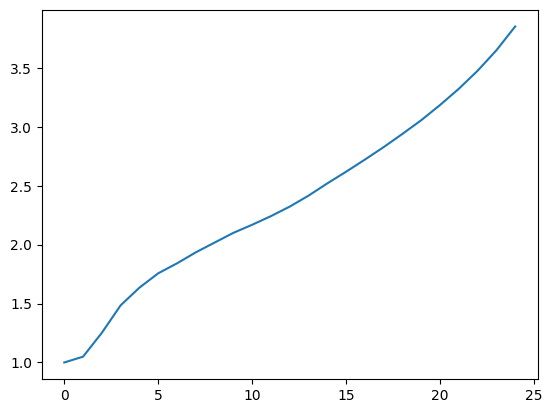

In [51]:
plt.plot(growth)

In [52]:
t = np.arange(len(growth)) + 1
exponent = np.log(growth) / t

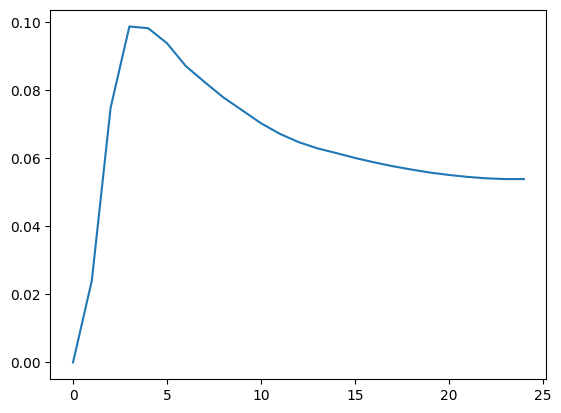

In [53]:
plt.plot(exponent)